# BioEngine Runner

In [2]:
import micropip
await micropip.install("kaibu_utils")

In [14]:
from imjoy import api
from imjoy_rpc.hypha import connect_to_server
import io
from PIL import Image
import numpy as np
import base64
import pyodide
from io import BytesIO
    
import numpy as np
import scipy.ndimage as ndi
from skimage import transform, util
from skimage import filters, measure, segmentation
from skimage.morphology import (binary_erosion, closing, disk,
                                remove_small_holes, remove_small_objects)

import numpy as np
from kaibu_utils import fetch_image, mask_to_features

import numpy as np
from skimage.transform import resize

nucleus_segmentation_model = "10.5281/zenodo.6200999"
cell_segmentation_model = "10.5281/zenodo.6200635"
classification_model = "10.5281/zenodo.5911832"

COLORS =  ["red", "green", "blue", "yellow"] # microtubule, protein, nuclei, ER
NORMALIZE = {"mean": [124 / 255, 117 / 255, 104 / 255], "std": [1 / (0.0167 * 255)] * 3}
HIGH_THRESHOLD = 0.4
LOW_THRESHOLD = HIGH_THRESHOLD - 0.25


LABELS = {
  0: 'Nucleoplasm',
  1: 'Nuclear membrane',
  2: 'Nucleoli',
  3: 'Nucleoli fibrillar center',
  4: 'Nuclear speckles',
  5: 'Nuclear bodies',
  6: 'Endoplasmic reticulum',
  7: 'Golgi apparatus',
  8: 'Intermediate filaments',
  9: 'Actin filaments',
  10: 'Microtubules',
  11: 'Mitotic spindle',
  12: 'Centrosome',
  13: 'Plasma membrane',
  14: 'Mitochondria',
  15: 'Aggresome',
  16: 'Cytosol',
  17: 'Vesicles and punctate cytosolic patterns',
  18: 'Negative',
}

COLORS =  ["red", "green", "blue", "yellow"]


async def fetch_hpa_image(image_id):
    crops = []
    for color in COLORS:
        image = await fetch_image(f'https://images.proteinatlas.org/{image_id}_{color}.jpg', grayscale=True)
        crops.append(image)
    image = np.stack(crops, axis=0)
    # assert image.shape == (4, 128, 128)
    return image

def __fill_holes(image):
    """Fill_holes for labelled image, with a unique number."""
    boundaries = segmentation.find_boundaries(image)
    image = np.multiply(image, np.invert(boundaries))
    image = ndi.binary_fill_holes(image > 0)
    image = ndi.label(image)[0]
    return image


def label_nuclei(nuclei_pred):
    """Return the labeled nuclei mask data array.
    This function works best for Human Protein Atlas cell images with
    predictions from the CellSegmentator class.
    Keyword arguments:
    nuclei_pred -- a 3D numpy array of a prediction from a nuclei image.
    Returns:
    nuclei-label -- An array with unique numbers for each found nuclei
                    in the nuclei_pred. A value of 0 in the array is
                    considered background, and the values 1-n is the
                    areas of the cells 1-n.
    """
    img_copy = np.copy(nuclei_pred[..., 2])
    borders = (nuclei_pred[..., 1] > 0.05).astype(np.uint8)
    m = img_copy * (1 - borders)

    img_copy[m <= LOW_THRESHOLD] = 0
    img_copy[m > LOW_THRESHOLD] = 1
    img_copy = img_copy.astype(np.bool)
    img_copy = binary_erosion(img_copy)
    # TODO: Add parameter for remove small object size for
    #       differently scaled images.
    # img_copy = remove_small_objects(img_copy, 500)
    img_copy = img_copy.astype(np.uint8)
    markers = measure.label(img_copy).astype(np.uint32)

    mask_img = np.copy(nuclei_pred[..., 2])
    mask_img[mask_img <= HIGH_THRESHOLD] = 0
    mask_img[mask_img > HIGH_THRESHOLD] = 1
    mask_img = mask_img.astype(np.bool)
    mask_img = remove_small_holes(mask_img, 1000)
    # TODO: Figure out good value for remove small objects.
    # mask_img = remove_small_objects(mask_img, 8)
    mask_img = mask_img.astype(np.uint8)
    nuclei_label = segmentation.watershed(
        mask_img, markers, mask=mask_img, watershed_line=True
    )
    nuclei_label = remove_small_objects(nuclei_label, 2500)
    nuclei_label = measure.label(nuclei_label)
    return nuclei_label


def label_cell(nuclei_pred, cell_pred):
    """Label the cells and the nuclei.
    Keyword arguments:
    nuclei_pred -- a 3D numpy array of a prediction from a nuclei image.
    cell_pred -- a 3D numpy array of a prediction from a cell image.
    Returns:
    A tuple containing:
    nuclei-label -- A nuclei mask data array.
    cell-label  -- A cell mask data array.
    0's in the data arrays indicate background while a continous
    strech of a specific number indicates the area for a specific
    cell.
    The same value in cell mask and nuclei mask refers to the identical cell.
    NOTE: The nuclei labeling from this function will be sligthly
    different from the values in :func:`label_nuclei` as this version
    will use information from the cell-predictions to make better
    estimates.
    """
    def __wsh(
        mask_img,
        threshold,
        border_img,
        seeds,
        threshold_adjustment=0.35,
        small_object_size_cutoff=10,
    ):
        img_copy = np.copy(mask_img)
        m = seeds * border_img  # * dt
        img_copy[m <= threshold + threshold_adjustment] = 0
        img_copy[m > threshold + threshold_adjustment] = 1
        img_copy = img_copy.astype(np.bool)
        img_copy = remove_small_objects(img_copy, small_object_size_cutoff).astype(
            np.uint8
        )

        mask_img[mask_img <= threshold] = 0
        mask_img[mask_img > threshold] = 1
        mask_img = mask_img.astype(np.bool)
        mask_img = remove_small_holes(mask_img, 1000)
        mask_img = remove_small_objects(mask_img, 8).astype(np.uint8)
        markers = ndi.label(img_copy, output=np.uint32)[0]
        labeled_array = segmentation.watershed(
            mask_img, markers, mask=mask_img, watershed_line=True
        )
        return labeled_array

    nuclei_label = __wsh(
        nuclei_pred[..., 2] / 255.0,
        0.4,
        1 - (nuclei_pred[..., 1] + cell_pred[..., 1]) / 255.0 > 0.05,
        nuclei_pred[..., 2] / 255,
        threshold_adjustment=-0.25,
        small_object_size_cutoff=500,
    )

    # for hpa_image, to remove the small pseduo nuclei
    nuclei_label = remove_small_objects(nuclei_label, 2500)
    nuclei_label = measure.label(nuclei_label)
    # this is to remove the cell borders' signal from cell mask.
    # could use np.logical_and with some revision, to replace this func.
    # Tuned for segmentation hpa images
    threshold_value = max(0.22, filters.threshold_otsu(cell_pred[..., 2] / 255) * 0.5)
    # exclude the green area first
    cell_region = np.multiply(
        cell_pred[..., 2] / 255 > threshold_value,
        np.invert(np.asarray(cell_pred[..., 1] / 255 > 0.05, dtype=np.int8)),
    )
    sk = np.asarray(cell_region, dtype=np.int8)
    distance = np.clip(cell_pred[..., 2], 255 * threshold_value, cell_pred[..., 2])
    cell_label = segmentation.watershed(-distance, nuclei_label, mask=sk)
    cell_label = remove_small_objects(cell_label, 5500).astype(np.uint8)
    selem = disk(6)
    cell_label = closing(cell_label, selem)
    cell_label = __fill_holes(cell_label)
    # this part is to use green channel, and extend cell label to green channel
    # benefit is to exclude cells clear on border but without nucleus
    sk = np.asarray(
        np.add(
            np.asarray(cell_label > 0, dtype=np.int8),
            np.asarray(cell_pred[..., 1] / 255 > 0.05, dtype=np.int8),
        )
        > 0,
        dtype=np.int8,
    )
    cell_label = segmentation.watershed(-distance, cell_label, mask=sk)
    cell_label = __fill_holes(cell_label)
    cell_label = np.asarray(cell_label > 0, dtype=np.uint8)
    cell_label = measure.label(cell_label)
    cell_label = remove_small_objects(cell_label, 5500)
    cell_label = measure.label(cell_label)
    cell_label = np.asarray(cell_label, dtype=np.uint16)
    nuclei_label = np.multiply(cell_label > 0, nuclei_label) > 0
    nuclei_label = measure.label(nuclei_label)
    nuclei_label = remove_small_objects(nuclei_label, 2500)
    nuclei_label = np.multiply(cell_label, nuclei_label > 0)

    return nuclei_label, cell_label



def preprocess(image, scale_factor=0.25):
    assert len(image.shape) == 3
    image = transform.rescale(image, scale_factor, multichannel=True)
    # nuc_image = np.dstack((image[..., 2], image[..., 2], image[..., 2]))
    image = image.transpose([2, 0, 1])
    return image

def run_model_torch(model, imgs, scale_factor=0.25):
    import torch
    imgs = torch.tensor(imgs).float()
    mean = torch.as_tensor(NORMALIZE["mean"])
    std = torch.as_tensor(NORMALIZE["std"])
    imgs = imgs.sub_(mean[:, None, None]).div_(std[:, None, None])
    # np.save("test_input.npy", imgs)
    imgs = model(imgs)
    imgs = imgs.to("cpu").detach().numpy()
    # np.save("test_output.npy", imgs)
    imgs = transform.rescale(imgs[0].transpose([1, 2, 0]), 1.0/scale_factor, multichannel=True)
    imgs = util.img_as_ubyte(imgs)
    return imgs

async def segment(model_runner, model, imgs, scale_factor=0.25):
    imgs = preprocess(imgs, scale_factor=0.25)
    image = imgs[None, :, :, :].astype('float32')
    result = await model_runner.execute_model([image], model)
    imgs = result['outputs'][0]
    # np.save("test_output.npy", imgs)
    imgs = transform.rescale(imgs[0].transpose([1, 2, 0]), 1.0/scale_factor, multichannel=True)
    imgs = util.img_as_ubyte(imgs)
    return imgs

async def classify(model_runner, model, image, threshold=0.3, expected_shape=[4, 128, 128]):
    image = image.transpose(2, 0, 1)  # HxWxC to CxHxW
    image = resize(image, expected_shape)
    # plt.imshow(image[0:3, :, :].transpose(1,2,0))
    # after resizing, the pixel range will become 0~1
    image *= 255
    image = image[None, :, :, :].astype('float32')
    result = await model_runner.execute_model([image], model)
    classes, features = result['outputs']
    preds = [(LABELS[i], prob) for i, prob in enumerate(classes[0].tolist()) if prob>threshold]
    return preds


def cell_crop_augment(image, mask, paddings=(20, 20, 20, 20)):
    top, bottom, left, right = paddings
    label_image = measure.label(mask)
    max_area = 0
    for region in measure.regionprops(label_image):
        if region.area > max_area:
            max_area = region.area
            min_row, min_col, max_row, max_col = region.bbox

    min_row, min_col = max(min_row - top, 0), max(min_col - left, 0)
    max_row, max_col = min(max_row + bottom, mask.shape[0]), min(max_col + right, mask.shape[1])

    image = image[min_row:max_row, min_col:max_col]
    mask = mask[min_row:max_row, min_col:max_col]
    return image, mask

def generate_cell_indices(cell_mask):
    cell_indices = np.sort(list(set(np.unique(cell_mask).tolist()) - {0, }))
    return cell_indices.tolist()

def crop_image(image_raw, mask_raw, image_id, save_dir=None, save_rgby=False):
    cell_indices = generate_cell_indices(mask_raw)
    crop_images = []
    for maskid in cell_indices:
        image = image_raw.copy()
        mask = mask_raw.copy()
        image[mask != maskid] = 0
        image, _ = cell_crop_augment(image, (mask == maskid).astype('uint8'))
        if save_dir:
            save_fname = f'{save_dir}/{image_id}_{maskid}.png'
            cv2.imwrite(save_fname, image if save_rgby else image[:, :, :3]) # ignore the alpha channel
        crop_images.append(image)
    return cell_indices, crop_images

def read_image(bytes, name=None, grayscale=False, size=None):
    buffer = io.BytesIO(bytes)
    buffer.name = name or url.split('?')[0].split('/')[1]
    image = Image.open(buffer).convert('L')
    if grayscale:
        image = image.convert('L')
    if size:
        image = image.resize(size=size)
    image = np.array(image)
    return image


def encode_image(image):
    image = Image.fromarray(image)
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = 'data:image/png;base64,' + base64.b64encode(buffered.getvalue()).decode('ascii')
    return img_str

    
async def get_bioengine_runner():  
    api = await connect_to_server(
        {"name": "test client", "server_url": "https://ai.imjoy.io/"}
    )
    workspace = api.config.workspace
    # Find an imagej service
    public_services = await api.list_services("public")
    model_runner_service = list(filter(lambda service: service["name"] == "bioengine-model-runner", public_services))[-1]
    model_runner = await api.get_service(model_runner_service)
    await model_runner.load_model('10.5281/zenodo.5911832')
    await model_runner.get_current_model()
    return model_runner

## BioImage Model Runner

In [11]:
model_runner = await get_bioengine_runner()

In [12]:
# Reference: https://gist.github.com/oeway/98d543082545f897fef4796b1aac22dd

/lib/python3.9/site-packages/skimage/util/dtype.py:134: UserWarning: Possible precision loss when converting from float64 to uint8
  warn("Possible precision loss when converting from {} to {}"


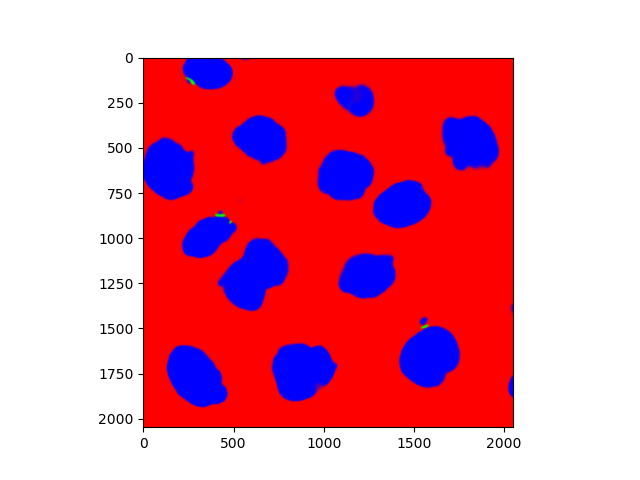

In [13]:
import matplotlib.pyplot as plt

image_id = '115/672_E2_1'
image_raw = await fetch_hpa_image(image_id)

nuc_image = image_raw[2, :, :]
nuc_image = np.stack((nuc_image, nuc_image, nuc_image), axis=-1)
# nuc_segmentations = run_model(nuclei_model, nuc_image[None, :, :, :])
nuc_segmentations = await segment(model_runner, nucleus_segmentation_model, nuc_image, scale_factor=0.25)

plt.imshow(nuc_segmentations)
plt.show()

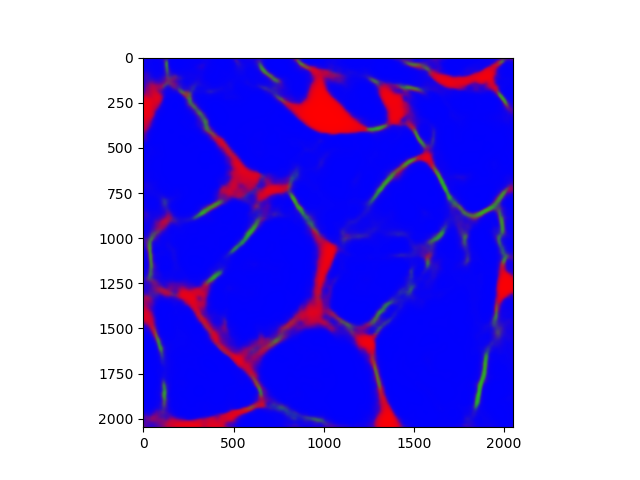

In [15]:
# microtubule/red, ER/yellow, nuclei/blue
cell_image = np.stack((image_raw[0, :, :], image_raw[3, :, :], image_raw[2, :, :]), axis=-1)
cell_segmentations = await segment(model_runner, cell_segmentation_model, cell_image, scale_factor=0.25)

plt.imshow(cell_segmentations)
plt.show()

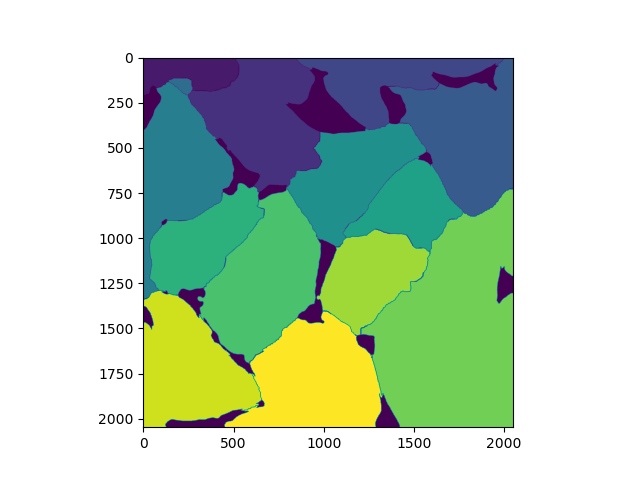

In [16]:
# post-processing
nuclei_mask = label_nuclei(nuc_segmentations)
nuclei_mask, cell_mask = label_cell(nuc_segmentations, cell_segmentations)
plt.imshow(cell_mask)
plt.show()


In [17]:
cell_indices, crop_images = crop_image(image_raw.transpose(1,2,0), cell_mask, image_id, None, False)
cell_predictions = {}
for mask_id, image_crop in zip(cell_indices, crop_images):
    preds = await classify(model_runner, classification_model, image_crop)
    cell_predictions[mask_id] = preds
    print(image_id, mask_id, preds)
    # classes, features = ort_session.run(None, {'image': image.astype(np.float32)})
    # preds = [(LABELS[i], prob) for i, prob in enumerate(classes[0].tolist()) if prob>threshold]
    # print(image_id, mask_id, preds, features.shape)

shapes = mask_to_features(np.flipud(cell_mask))
names = []
for i in range(len(shapes)):
    pred = cell_predictions[i+1]
    label = [f'{p[0]}({p[1]:.2})' for p in pred]
    names.append(",".join(label))

115/672_E2_1 1 [('Negative', 0.9061329960823059)]
115/672_E2_1 2 [('Negative', 0.37430518865585327)]
115/672_E2_1 3 [('Cytosol', 0.6126110553741455)]
115/672_E2_1 4 [('Cytosol', 0.531792402267456)]
115/672_E2_1 5 [('Negative', 0.9180480241775513)]
115/672_E2_1 6 [('Negative', 0.7804083824157715)]
115/672_E2_1 7 [('Cytosol', 0.7767986059188843)]
115/672_E2_1 8 [('Plasma membrane', 0.3232407867908478), ('Negative', 0.4457925260066986)]
115/672_E2_1 9 [('Negative', 0.8883349299430847)]
115/672_E2_1 10 [('Cytosol', 0.4648425281047821), ('Negative', 0.48192963004112244)]
115/672_E2_1 11 [('Negative', 0.5237125754356384)]
115/672_E2_1 12 [('Negative', 0.9320293664932251)]
115/672_E2_1 13 [('Cytosol', 0.6846230626106262)]
115/672_E2_1 14 [('Cytosol', 0.556601881980896), ('Negative', 0.3250664472579956)]


In [18]:
from kaibu_utils import mask_to_features
from imjoy_rpc import api

viewer = None
class Plugin:
    async def setup(self):
        global viewer
        viewer = await api.createWindow(
            name="Kaibu", src="https://kaibu.org/#/app"
        )
        url = f'https://images.proteinatlas.org/{image_id}_blue_red_green.jpg'
        await viewer.view_image(url)
        view = await viewer.add_shapes(shapes, label=names, text_placement='point', edge_color='#4FED10')

api.export(Plugin())

<IPython.core.display.Javascript object>

<Future finished result=[]>